# Using python and machine learning to predict energy consumption

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import mean_squared_error

In [2]:
sns.set()

## Importing data

In [3]:
filepath = "/home/jvictor/vs_code/time_series_forecasting_with_xgboost/energy_consumption/data/PJME_hourly.csv"
df = pd.read_csv(filepath)

In [4]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [9]:
df.Datetime = pd.to_datetime(df["Datetime"])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


In [11]:
df.set_index("Datetime", inplace=True)

In [12]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


## Visualizing data

<AxesSubplot:title={'center':'PJME Energy Use in MW'}, xlabel='Datetime'>

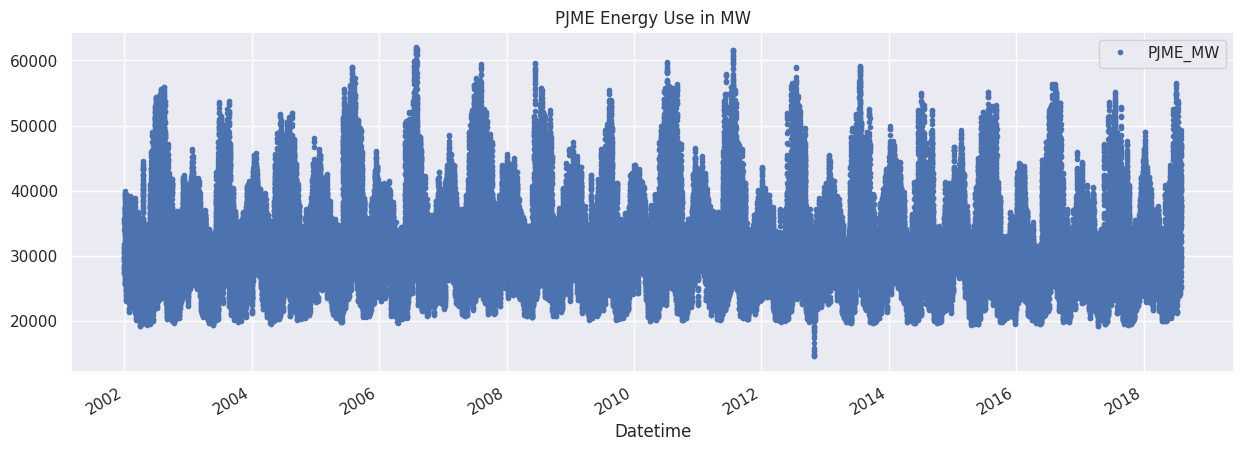

In [14]:
df.plot(style=".", figsize=(15,5), title="PJME Energy Use in MW")

## Data preparation: Train / Test split

In [15]:
split_date_point = '01-01-2015'
data_filter_less = df.index < split_date_point
data_filter_geq = df.index >= split_date_point

train = df.loc[data_filter_less]
test = df.loc[data_filter_geq]

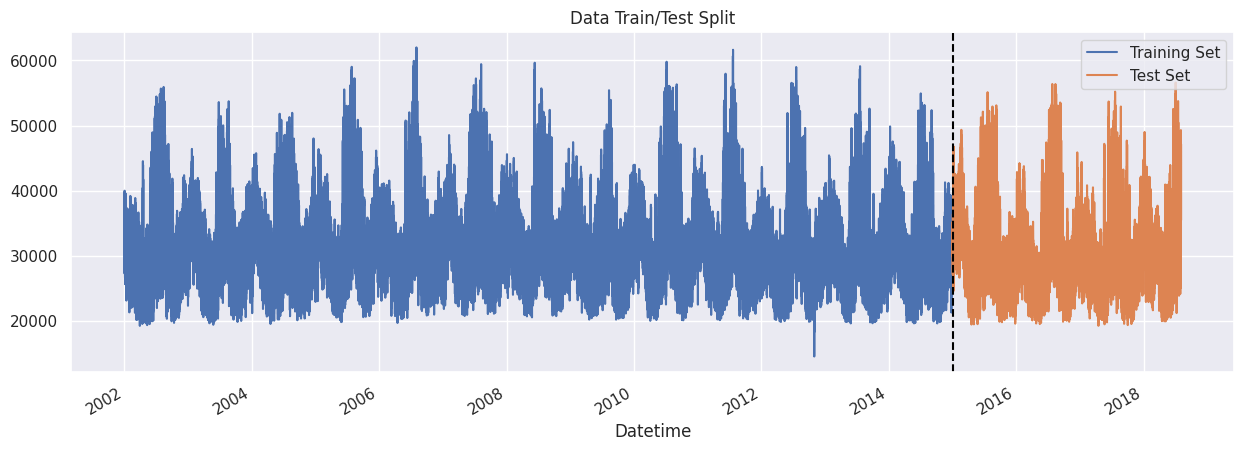

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label="Training Set", title="Data Train/Test Split")
test.plot(ax=ax, label="Test Set")
ax.axvline(split_date_point, color="black", ls="--")
ax.legend(["Training Set", "Test Set"])

## Visualizing data of one week

<AxesSubplot:xlabel='Datetime'>

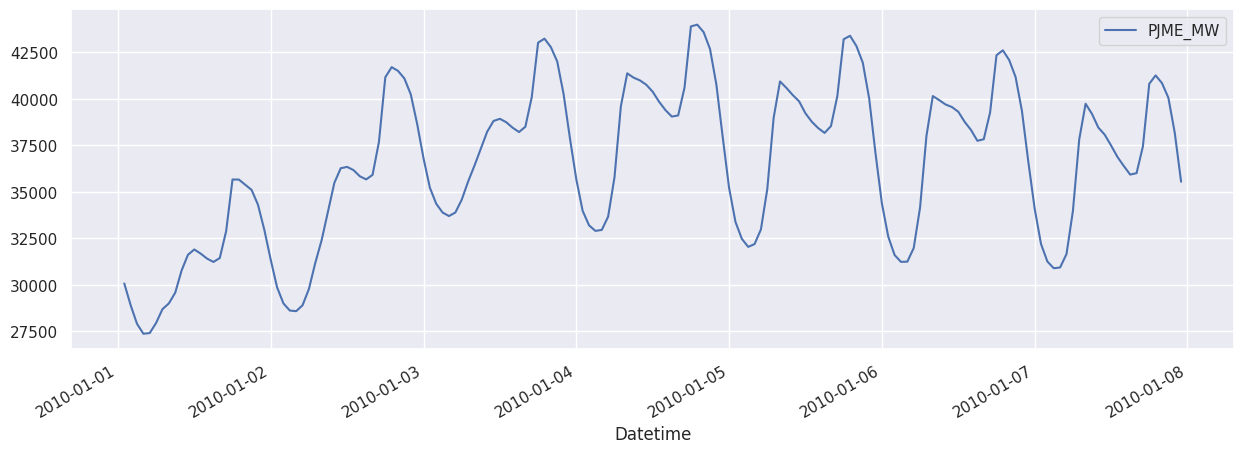

In [20]:
one_week_of_data_filter = (df.index > '01-01-2010') & (df.index < '01-08-2010')
df.loc[one_week_of_data_filter].plot(figsize=(15,5))

## Feature Creation

In [28]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Creates time series features based on time series index 
    and adds these new features to a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame that we want to add new features.

    Returns:
        pd.DataFrame: An updated DataFrame with new features.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    
    return df

In [23]:
df = create_features(df=df)

## Visualize our Feature / Target Relantionship

Text(0.5, 1.0, 'MW by hour')

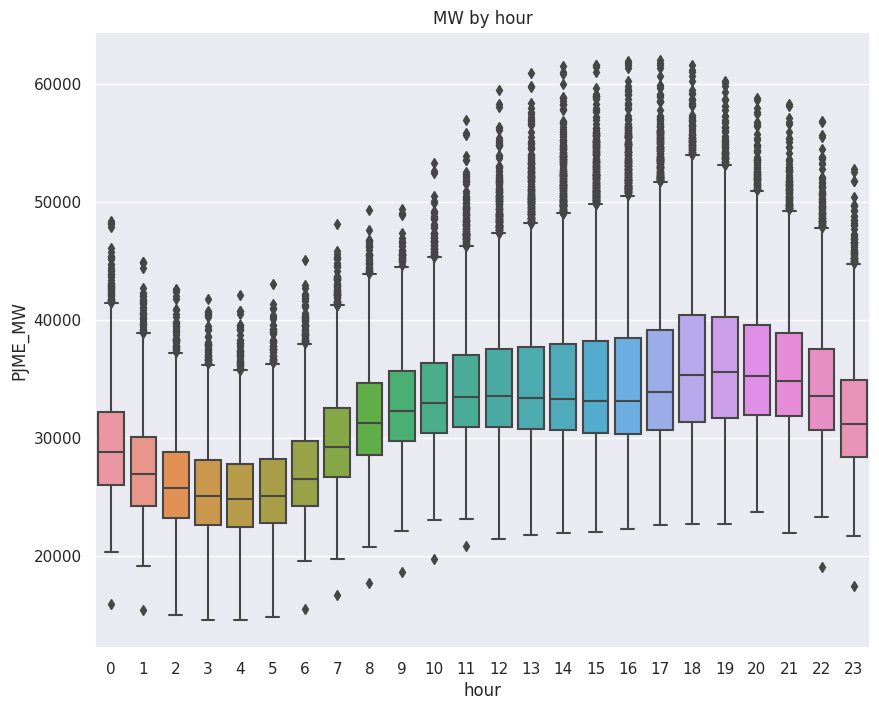

In [25]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x="hour", y="PJME_MW")
ax.set_title("MW by hour")

Text(0.5, 1.0, 'MW by month')

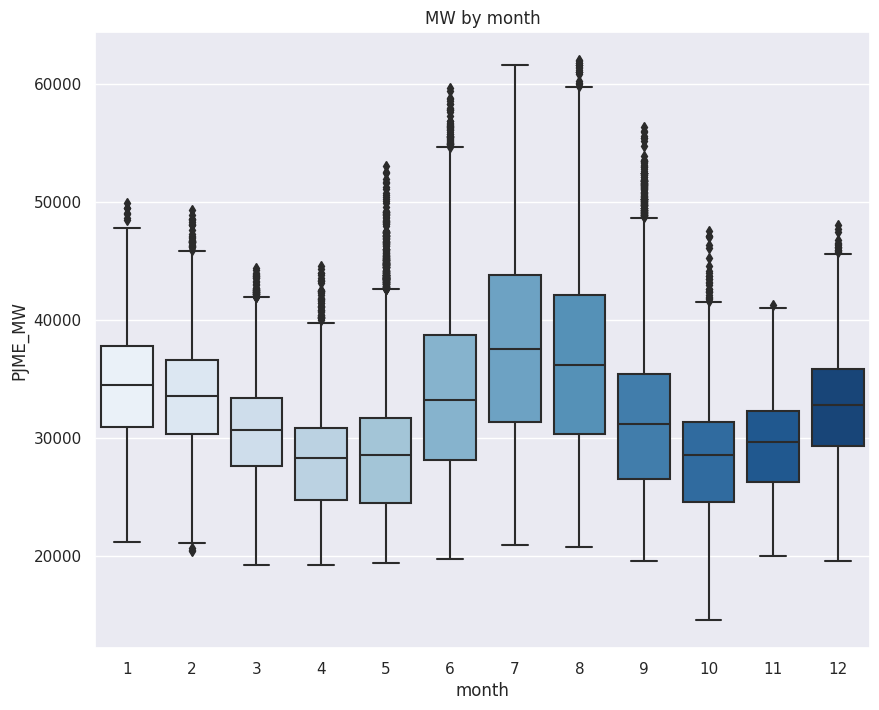

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x="month", y="PJME_MW", palette="Blues")
ax.set_title("MW by month")

## Creating the model

In [29]:
train = create_features(train)
test = create_features(test)

In [32]:
FEATURES = [column for column in df.columns if column != "PJME_MW"]
TARGET = df.columns[0]

In [34]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [37]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.13873	validation_1-rmse:11517.66004
[200]	validation_0-rmse:5373.33346	validation_1-rmse:5165.30811
[300]	validation_0-rmse:3375.20923	validation_1-rmse:3829.25476
[400]	validation_0-rmse:2882.55200	validation_1-rmse:3715.04915
[437]	validation_0-rmse:2793.31200	validation_1-rmse:3727.16078


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

## Feature Importance

In [38]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"])

In [39]:
fi

,importance
hour,0.448121
dayofweek,0.159098
quarter,0.029913
month,0.230090
year,0.022350
dayofyear,0.110429


<AxesSubplot:title={'center':'Feature Importance'}>

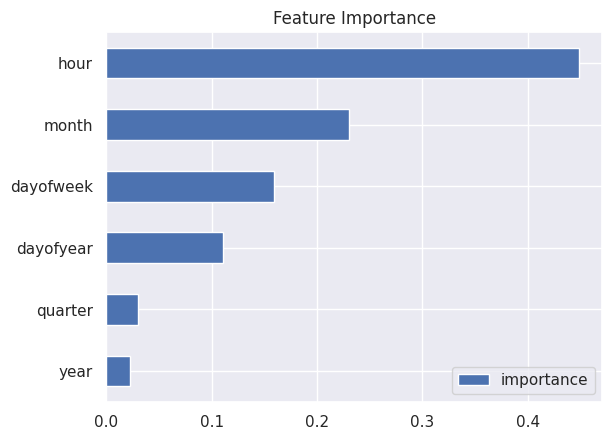

In [40]:
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")

## Forecast on test

In [41]:
test["prediction"] = reg.predict(X_test)

In [43]:
df = df.merge(test[["prediction"]], how="left", left_index=True, right_index=True)

Text(0.5, 1.0, 'Raw Data and Prediction')

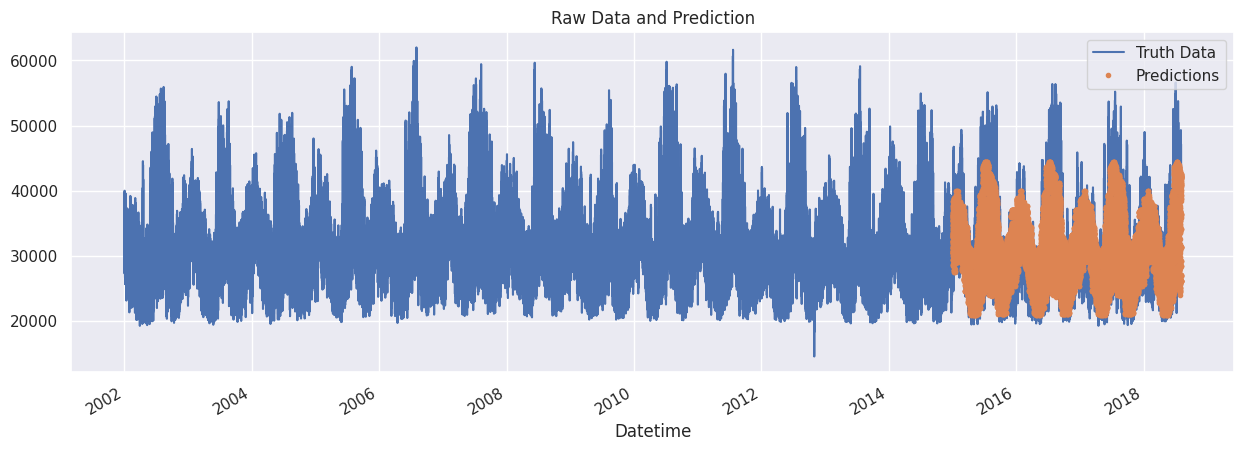

In [45]:
ax = df[["PJME_MW"]].plot(figsize=(15,5))
df["prediction"].plot(ax=ax, style=".")
ax.legend(["Truth Data", "Predictions"])
ax.set_title("Raw Data and Prediction")

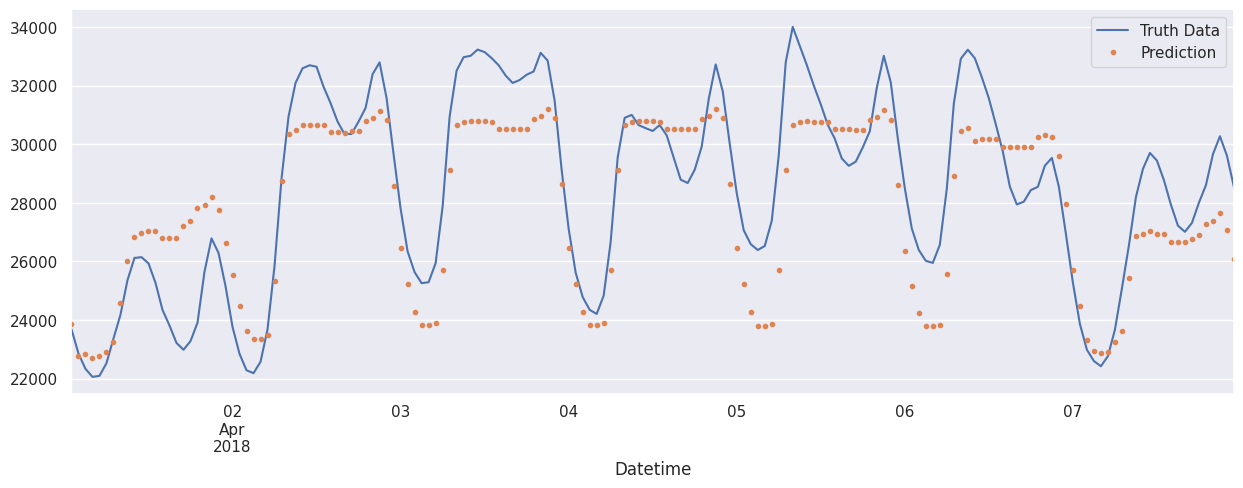

In [46]:
one_week_of_data_filter = (df.index > '04-01-2018') & (df.index < '04-08-2018')
ax = df.loc[one_week_of_data_filter]["PJME_MW"].plot(figsize=(15,5))
df.loc[one_week_of_data_filter]["prediction"].plot(style=".")
ax.legend(["Truth Data", "Prediction"])

## Calculate Error

In [47]:
mean_squared_error(test["PJME_MW"], test["prediction"])

13797734.544390151

In [48]:
score = np.sqrt(mean_squared_error(test["PJME_MW"], test["prediction"]))
print(f"RMSE Score on Test set: {score:0.2f}")

RMSE Score on Test set: 3714.53


In [49]:
test["error"] = np.abs(test[TARGET] - test["prediction"])

* Look at the worst and best predicted days

In [50]:
test["date"] = test.index.date

In [52]:
test.groupby("date")["error"].mean().sort_values(ascending=False).head(5)

date
2016-08-13    14559.813965
2016-08-14    14393.350911
2016-09-10    12564.790202
2016-08-12    11527.895264
2016-09-09    11432.962240
Name: error, dtype: float64

In [53]:
test.groupby("date")["error"].mean().sort_values(ascending=True).head(5)

date
2016-09-27    376.074544
2016-05-01    420.460286
2016-04-04    432.775065
2015-03-10    444.994792
2016-12-08    480.121663
Name: error, dtype: float64